# Data Prep

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2
from sklearn.model_selection import train_test_split

(<Axes: >, <Axes: >)

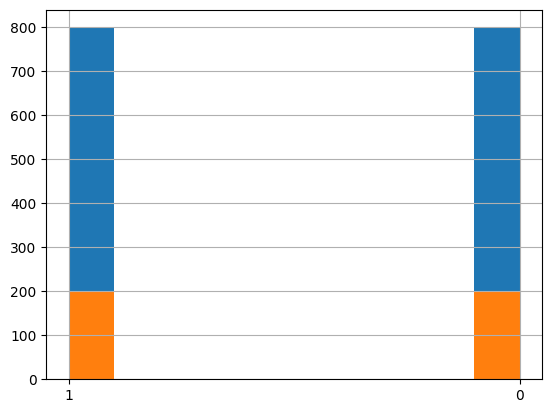

In [2]:
df = pd.read_csv("images/data.csv", sep="\t")
df.tortuous = df.tortuous.astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.tortuous, random_state=42)
train_df.tortuous.hist(), test_df.tortuous.hist()

In [3]:
BATCH_SIZE = 4
IMG_SIZE = 384
NUM_CLASSES = train_df["tortuous"].nunique()

In [4]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "tortuous",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    test_df,
    x_col = "filename",
    y_col = "tortuous",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [5]:
classes = train_df["tortuous"].unique()

In [6]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0}

# Train Global branch - Transformer

In [7]:
from vit_keras import vit, utils

e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you'

In [8]:
def create_vit_classifier():
    backbone_model = vit.vit_b16(
        image_size=IMG_SIZE,
        activation="sigmoid",
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )

    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(backbone_model.output)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    classifier = tf.keras.layers.Dense(units = NUM_CLASSES, activation = 'softmax')(leaky_relu)
    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [9]:
global_model = create_vit_classifier()

In [10]:
global_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 24, 24, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 576, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 577, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 577, 768)         443136    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 577, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [11]:
global_model.load_weights("models_tf/10_0.221_0.975.h5")

In [ ]:
EPOCHS = 100

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_tf/{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True )
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]
mycallbacks = [learning_rate_reduction, checkpoint] # disable early stop

In [ ]:
history = global_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = global_model.evaluate(val_generator)
print(val_loss, val_accuracy)

In [ ]:
global_model.save_weights(f"models_tf/100_{val_loss:.3f}_{val_accuracy:.3f}.h5")

# Visualize Attention Map

In [12]:
from vit_keras import layers, vit

In [13]:
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).

    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    img_height, img_width = model.input_shape[1], model.input_shape[2]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2] - 1))

    # Prepare the input
    # X = vit.preprocess_inputs(cv2.resize(image, (img_height, img_width)))[np.newaxis, :]  # type: ignore
    X = np.expand_dims(image, axis=0)

    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.TransformerBlock)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.max(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    return mask

In [14]:
def overlay_heatmap(heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

In [15]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [16]:
images, labels = training_generator.next()

In [17]:
print(tf.argmax(labels, axis=1))

tf.Tensor([0 0 0 0], shape=(4,), dtype=int64)


In [18]:
heatmaps = [attention_map(model=global_model, image=img) for img in images]

e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 161ms/step


In [19]:
overlaid_images = [overlay_heatmap(hmap, img, alpha=0.8) for (hmap, img) in zip(heatmaps, images)]

In [20]:
print(tf.argmax(labels, axis=1))
print(tf.argmax(global_model(images), axis=1))

tf.Tensor([0 0 0 0], shape=(4,), dtype=int64)
tf.Tensor([0 0 0 0], shape=(4,), dtype=int64)


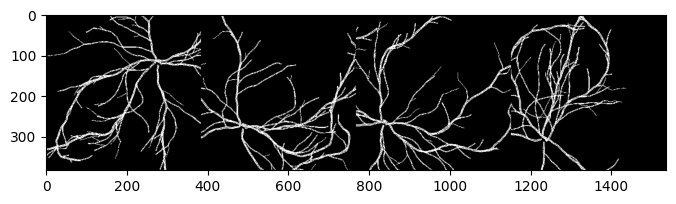

In [21]:
# Input images
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(images), cmap="jet")

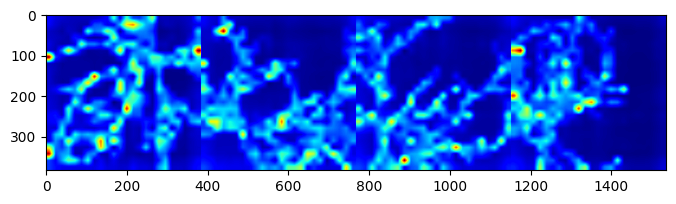

In [22]:
# Attention maps
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in heatmaps]), cmap="jet")

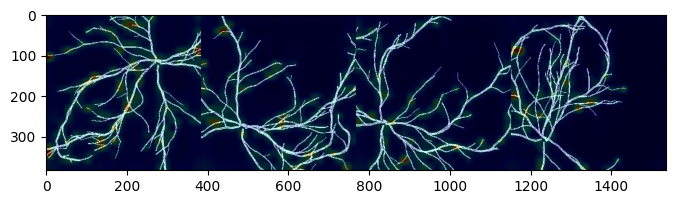

In [23]:
# Overlaid images
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(overlaid_images), cmap="jet")

In [ ]:
OUTPUT_FOLDER = "AttRollout_Outputs_max"
!mkdir "$OUTPUT_FOLDER"

In [ ]:
IMAGE_START = 32

In [ ]:
!mkdir "$OUTPUT_FOLDER/images"
for img_id, (img, label) in enumerate(zip(images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/images/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/attnmaps"
for img_id, (img, label) in enumerate(zip(heatmaps, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/attnmaps/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img.squeeze(), cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/overlaid"
for img_id, (img, label) in enumerate(zip(overlaid_images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/overlaid/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

# Metrics

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [25]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    bacc = balanced_accuracy_score(y_true, y_pred_max)
    print("Balanced Accuracy: ", bacc)
    
    precision = precision_score(y_true, y_pred_max, average='weighted')
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average='weighted')
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average='weighted')
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred_max, average='weighted', multi_class='ovr')
    print("AUC: ", auc)

In [26]:
def pred_global(images, labels):
    return global_model(images, training=False)

In [27]:
get_metrics(pred_global)

99/100
Accuracy:  0.975
Balanced Accuracy:  0.975
Precision:  0.975047504750475
Recall:  0.975
F1:  0.9749993749843746
AUC:  0.975
